In [1]:
import numpy as np
from WorldCupTeam import WorldCupTeam
from WorldCupSim import WorldCupSim
import WorldCupMetrics as met
import copy as copy
import pandas as pd
import random 

random.seed(40)
def get_WorldCup2022_data():
    teamdata = pd.read_excel('WorldCup2022_Teams.xlsx')
    return teamdata
                    
# ************ Simulations Parameters ***************
hostname = 'Qatar'
Nsims = 100 # number of tournament simulations to run
verbose = False # set to true to print outcome of all matches and group tables in each sim iteration
savePlots = True # plots saved in same directory

# ************ Sim Set-up ***************
print("loading data")
teamdata = get_WorldCup2022_data()
group_names = sorted(np.unique(teamdata['Group']))
teamnames = list( teamdata['Team'].values )
sims = []

# ************ MAIN SIMULATIONS LOOP ***************
print("starting sims: 0 sims done")
for i in range(0,Nsims):
    # collect team data (needs to be redone in each loop of sim)
    teams = []
    for ix,row in teamdata.iterrows():
        teams.append( WorldCupTeam( row['Group'],row['Team'],row['Elo'],hostname,row["Moving goals for"],row["Moving goals against"]) )

    # initialise simulation
    s = WorldCupSim(group_names,teams,verbose=verbose)
    
    # run simulated world cup
    s.runsim() 
    sims.append(copy.deepcopy(s))

    if i>0 and i % 100 == 0: 
        print("               %s sims done" % (i))

loading data
starting sims: 0 sims done


In [2]:
import urllib.request
import matplotlib
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.formatters import decimal_to_percent
from plottable.plots import circled_image # image
import matplotlib.pyplot as plt

In [3]:
def TraceTeam_daniel(sims,teamname, verbose=False):
    # trace probability of a team progressing through the tournament
    Progress = []
    Nsims = float(len(sims))
    stages = ['GRP','R16','QF','SF','Final','Winner']
    for s in sims:
        p = 0
        if teamname in s.KnockOut.R16teamnames: p += 1
        if teamname in s.KnockOut.QFteamnames: p += 1
        if teamname in s.KnockOut.SFteamnames: p += 1
        if teamname in s.KnockOut.Finalteamnames: p += 1
        if teamname == s.KnockOut.Final[0].winner.name: p += 1
        Progress.append(stages[p])    
    ProgressFreq = [Progress.count(s)/Nsims for s in stages]
    assert np.isclose( np.sum(ProgressFreq),1.,atol=0.001,rtol=0.0)
    ProgressFreq = 1-np.cumsum(ProgressFreq)
    Progress = (teamname,ProgressFreq[0],ProgressFreq[1],ProgressFreq[2],ProgressFreq[3],ProgressFreq[4]) 
    data = {'Team':teamname,'Rd of 16':ProgressFreq[0],'Quarter finals':ProgressFreq[1],'SemiFinals':ProgressFreq[2],'Final':ProgressFreq[3],'WC':ProgressFreq[4]}
    dataframe = pd.DataFrame(data,index=[1])
    if verbose:
        print("%s: %1.2f,%1.2f,%1.2f,%1.2f,%1.2f" % Progress)
    return dataframe

In [27]:
Codes = met.SetCodes()
Tables = [pd.DataFrame(met.ExpectedGroupFinishes(sims,group_names,group),columns=["Team","1st Prob","2nd Prob","3rd Prob","4th Prob"]) for group in group_names]

In [28]:
Tables[0]

,Team,1st Prob,2nd Prob,3rd Prob,4th Prob
0,Netherlands,0.44,0.24,0.19,0.13
1,Qatar,0.23,0.34,0.24,0.19
2,Senegal,0.25,0.20,0.27,0.28
3,Ecuador,0.08,0.22,0.30,0.40


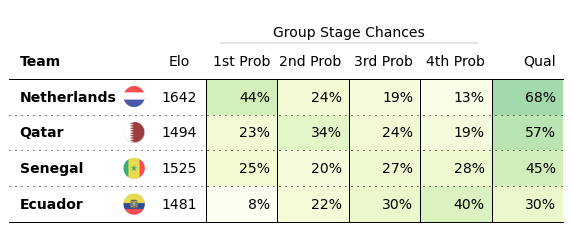

In [26]:
fig,ax = plt.subplots(figsize=(10, 4))

df=Tables[0].copy()
df['Qual']=df.iloc[:,[1,2]].sum(axis=1)
df=teamdata[["Team","Elo"]].merge(df,on='Team',how='right').round(2).sort_values('Qual',ascending=False).reset_index(drop=True)
country_to_flagpath = {x: met.team_url(Codes[x]) for x in set(df["Team"])}
df.insert(0, "Flag", df["Team"].apply(lambda x: country_to_flagpath.get(x)))
df["Elo"]=df["Elo"].astype(int)
df=df.set_index("Team")
table = Table(
        df,
        column_definitions=col_defs,
        row_dividers=True,
        footer_divider=True,
        ax=ax,
        textprops={"fontsize": 14},
        row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
        col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
        column_border_kw={"linewidth": 1, "linestyle": "-"},)


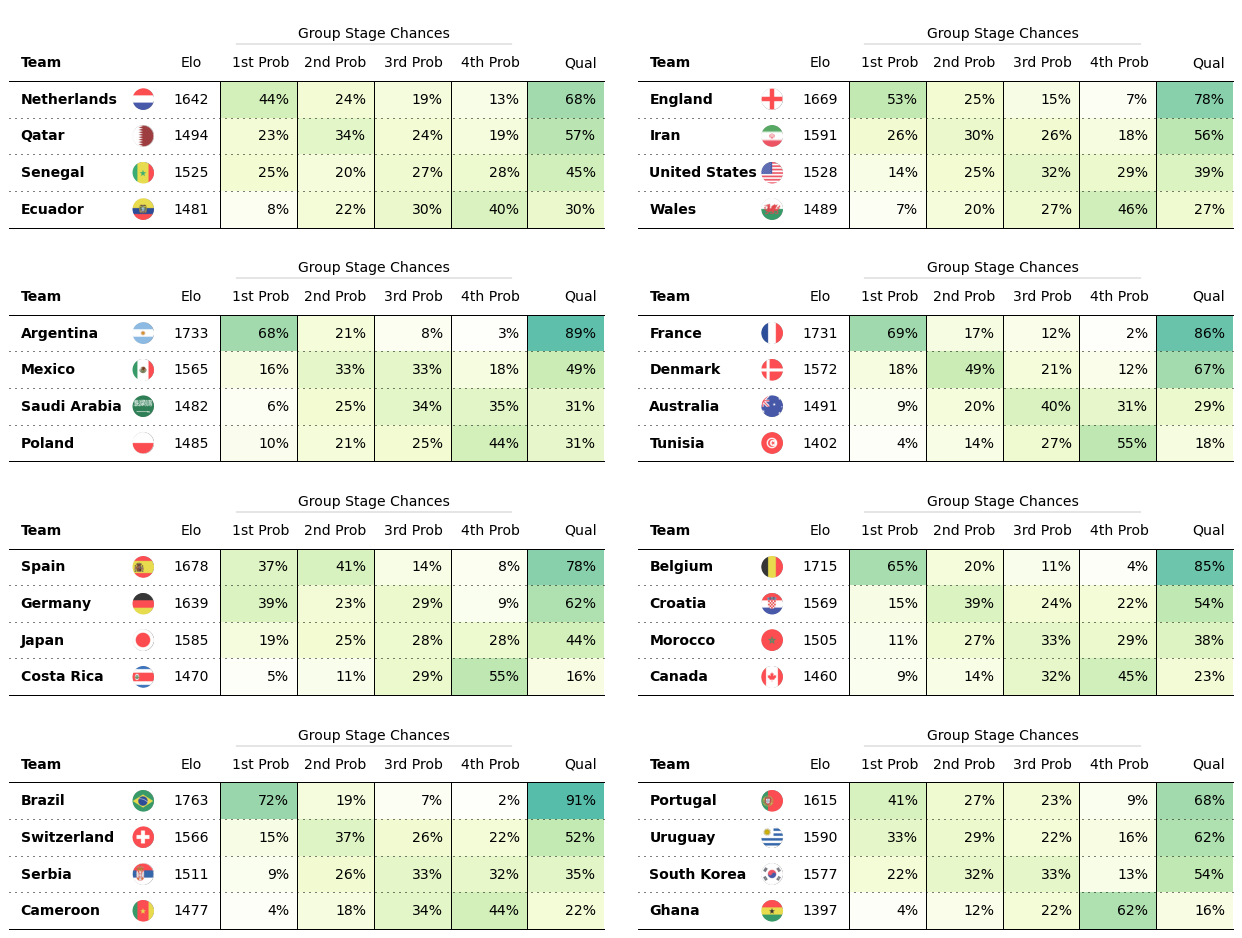

In [16]:
cmap = LinearSegmentedColormap.from_list(
        name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
    )

col_defs = (
    [
        ColumnDefinition(name="Flag",title="",textprops={"ha": "center"},width=0.5,plot_fn=circled_image,),
        ColumnDefinition(name="Team",textprops={"ha": "left", "weight": "bold"},width=1.5,), 
        ColumnDefinition(name="Group",textprops={"ha": "center"},width=0.75,),
        ColumnDefinition(name="Elo",textprops={"ha": "center"},width=0.75,),
        ColumnDefinition(name="1st Prob",formatter=decimal_to_percent,group="Group Stage Chances",border="left",cmap=cmap),
        ColumnDefinition(name="2nd Prob",formatter=decimal_to_percent,group="Group Stage Chances",border="left",cmap=cmap),
        ColumnDefinition(name="3rd Prob",formatter=decimal_to_percent,group="Group Stage Chances",border="left",cmap=cmap),
        ColumnDefinition(name="4th Prob",formatter=decimal_to_percent,group="Group Stage Chances",border="left",cmap=cmap),
        ColumnDefinition(name="Qual",formatter=decimal_to_percent,border="left",cmap=cmap)
    ]
)

fig,axes = plt.subplots(nrows=4,ncols=2,figsize=(22, 17))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.05, hspace=0.05)

for table,ax in zip(Tables,axes.flatten()):
        df=table.copy()
        df['Qual']=df.iloc[:,[1,2]].sum(axis=1)
        df=teamdata[["Team","Elo"]].merge(df,on='Team',how='right').round(2).sort_values('Qual',ascending=False).reset_index(drop=True)
        country_to_flagpath = {x: met.team_url(Codes[x]) for x in set(df["Team"])}
        df.insert(0, "Flag", df["Team"].apply(lambda x: country_to_flagpath.get(x)))
        df["Elo"]=df["Elo"].astype(int)
        df=df.set_index("Team")
        table = Table(
                df,
                column_definitions=col_defs,
                row_dividers=True,
                footer_divider=True,
                ax=ax,
                textprops={"fontsize": 14},
                row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
                col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
                column_border_kw={"linewidth": 1, "linestyle": "-"},)
